# Miniproject BIO-322: Predicting Heroin Purity
This repository contains the code, analysis, and results for the BIO-322 miniproject. The goal of this project is to predict the purity level of heroin samples using infrared spectra and machine learning techniques.

# Overview 
Confiscated drug samples often require purity analysis for legal and law enforcement purposes. Traditional methods, such as chromatography, are expensive and time-consuming. This project explores cost-effective and real-time solutions using machine learning models to analyze data from portable infrared spectrometry devices. The competition is hosted on Kaggle.

# Authors
Maëlys Clerget & Alice Priolet 

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from scipy.stats import chi2
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from bayes_opt import BayesianOptimization
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
import torch
import torch.nn as nn
import tqdm 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import copy
from sklearn.model_selection import train_test_split
import optuna
import os

my_seed = 42

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. DATA VISUALIZATION

In [8]:
def create_folder(path, folder_name):
    """
    Creates a folder with the specified name at the given path.
    
    Parameters:
        path (str): The directory where the folder should be created.
        folder_name (str): The name of the folder to create.
        
    Returns:
        str: The full path of the created folder.
    """
    # Combine path and folder name to create the full directory path
    full_path = os.path.join(path, folder_name)
    
    # Check if the folder already exists
    if not os.path.exists(full_path):
        os.makedirs(full_path)
        print(f"Folder '{folder_name}' created at '{path}'.")
    else:
        print(f"Folder '{folder_name}' already exists at '{path}'.")
    
    return full_path

In [9]:
# To change, enter your working directory / path
path = '/Users/maelysclerget/Desktop/ML/bio322_project/'

In [10]:
train_data_og = pd.read_csv(f'{path}train.csv')
test_data_og = pd.read_csv(f'{path}test.csv')

In [11]:
train_data = train_data_og.copy()
test_data = test_data_og.copy()

In [12]:
train_data_og.shape, test_data_og.shape

((1300, 131), (608, 130))

In [13]:
train_data_og.head()

,sample_name,device_serial,substance_form_display,measure_type_display,prod_substance,PURITY,908.1,914.3,920.5,926.7,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,11140009,M1-1000112,Homogenized Powder,Direct contact,Heroin,58.500000,0.044734,0.042720,0.041361,0.040055,...,0.003972,0.007906,0.012490,0.018123,0.025070,0.033235,0.042502,0.052237,0.061383,0.068823
1,22.0401-P002.02,M1-1000109,Non homogenized powder,Direct contact,Heroin,18.600000,0.063695,0.056980,0.050080,0.043339,...,0.093002,0.099668,0.108805,0.117120,0.121947,0.125137,0.128688,0.133501,0.138187,0.140248
2,22.0117-P001.02,M1-1000100,Non homogenized powder,Direct contact,Heroin,19.881719,0.050358,0.044910,0.039148,0.033730,...,0.083369,0.090485,0.100462,0.109033,0.113411,0.117053,0.121665,0.128366,0.134636,0.136961
3,20.0163-P009,N1-00196,Unspecified,Direct contact,Heroin,52.500000,0.525050,0.520434,0.517187,0.516377,...,0.357223,0.370060,0.386062,0.404460,0.425567,0.450527,0.479066,0.508943,0.539349,0.564486
4,19.0286-P005,N1-00196,Unspecified,Direct contact,Heroin,48.900000,0.479365,0.467401,0.456680,0.446148,...,0.350973,0.366094,0.384536,0.405034,0.426582,0.450564,0.477045,0.504142,0.531764,0.553650


In [14]:
# Display the column names
print("Column names:")
print(train_data_og.columns)

# Count the number of wavelength columns
# Assuming wavelength columns start from the 7th column (index 6)
spectral_cols = train_data_og.columns[6:]
num_spectral_cols = len(spectral_cols)

print(f"Number of wavelength columns: {num_spectral_cols}")

Column names:
Index(['sample_name', 'device_serial', 'substance_form_display',
       'measure_type_display', 'prod_substance', 'PURITY', '908.1', '914.3',
       '920.5', '926.7',
       ...
       '1620.5', '1626.6', '1632.8', '1639', '1645.2', '1651.4', '1657.6',
       '1663.8', '1670', '1676.2'],
      dtype='object', length=131)
Number of wavelength columns: 125


Max purity: 63.7
Min purity: 0.030500117
Highest frequency of purity: 139 in bin starting at 17.01


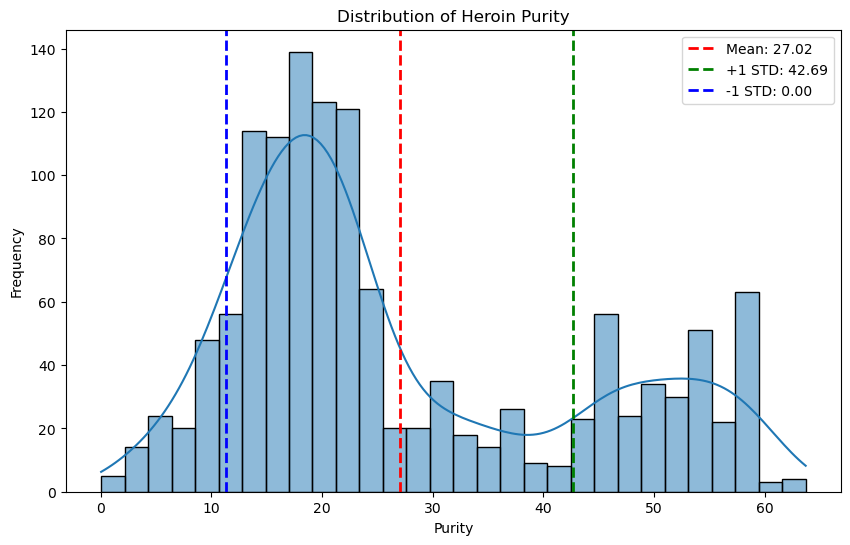

In [13]:
# Calculate mean, standard deviation, and maximum value of PURITY
mean = train_data_og['PURITY'].mean()
std = train_data_og['PURITY'].std()
max_purity = train_data_og['PURITY'].max()
print('Max purity:', max_purity)

min_purity = train_data_og['PURITY'].min()
print('Min purity:', min_purity)

# Calculate the histogram
hist, bin_edges = np.histogram(train_data_og['PURITY'], bins=30)

# Find the highest frequency and the corresponding bin
max_frequency = hist.max()
max_frequency_bin = bin_edges[np.argmax(hist)]

print(f'Highest frequency of purity: {max_frequency} in bin starting at {max_frequency_bin:.2f}')

# Plot the distribution of PURITY
plt.figure(figsize=(10, 6))
sns.histplot(train_data_og['PURITY'], bins=30, kde=True)
plt.xlabel('Purity')
plt.ylabel('Frequency')
plt.title('Distribution of Heroin Purity')

# Add a vertical line for the mean
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean + std:.2f}')
plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {std - std:.2f}')

plt.legend()
plt.show()



From the graph above, the response variable (Heroin Purity) appears to have a moderately skewed distribution, with a peak around 20 and a long tail towards higher values. This suggests that a log transformation might help normalize the data if needed for statistical analysis or modeling.

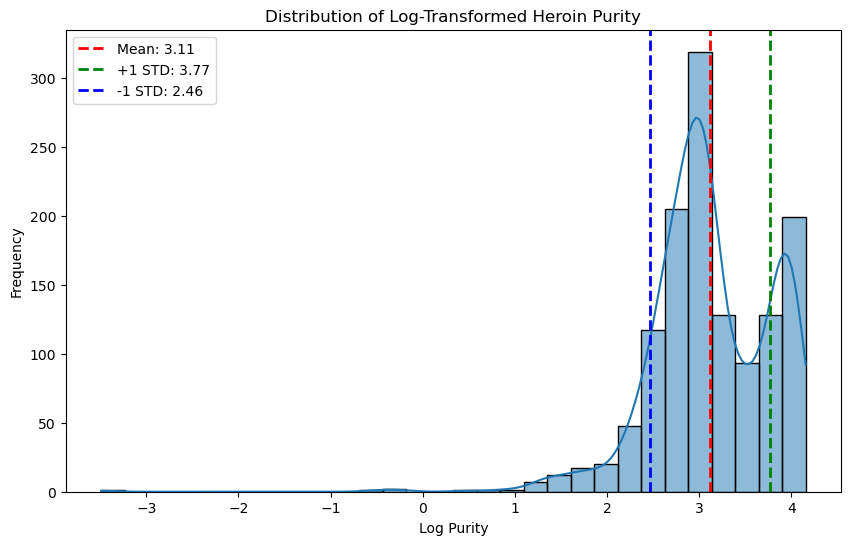

In [14]:
# Apply log transformation to the PURITY column
train_data_og['LOG_PURITY'] = np.log(train_data_og['PURITY'])

# Calculate mean, standard deviation, and maximum value of LOG_PURITY
log_mean = train_data_og['LOG_PURITY'].mean()
log_std = train_data_og['LOG_PURITY'].std()
log_max_purity = train_data_og['LOG_PURITY'].max()
log_min_purity = train_data_og['LOG_PURITY'].min()

# Calculate the histogram
log_hist, log_bin_edges = np.histogram(train_data_og['LOG_PURITY'], bins=30)

# Find the highest frequency and the corresponding bin
log_max_frequency = log_hist.max()
log_max_frequency_bin = log_bin_edges[np.argmax(log_hist)]

# Plot the distribution of LOG_PURITY
plt.figure(figsize=(10, 6))
sns.histplot(train_data_og['LOG_PURITY'], bins=30, kde=True)
plt.xlabel('Log Purity')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Heroin Purity')

# Add a vertical line for the mean
plt.axvline(log_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {log_mean:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(log_mean + log_std, color='green', linestyle='dashed', linewidth=2, label=f'+1 STD: {log_mean + log_std:.2f}')
plt.axvline(log_mean - log_std, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {log_mean - log_std:.2f}')

plt.legend()
plt.show()

The distribution is now closer to normal (bell-shaped) after applying the log transformation. Most values are concentrated around the mean (approximately 3.11) with fewer extreme values in both directions.

# II. DATA PREPROCESSING

In [15]:
# Predit score
def scoring(y_pred, y_true):
    err = np.abs(y_pred - y_true)
    frac = (err <= 5).astype(int)
    return np.mean(frac)

In [16]:
# Submission file for kaggle 
def submission_file(y_test_predicted):
    submission_reduced = pd.DataFrame({
        'ID': range(1, len(y_test_predicted) + 1),
        'PURITY': y_test_predicted
    })
    return submission_reduced

In [17]:
def plot_raw_vs_filtered(raw_signal, filtered_signal, spectral_cols, sample_idx=0):
    """
    Plots the raw and filtered signal for comparison.
    
    Args:
        raw_signal: DataFrame of the raw signal.
        filtered_signal: DataFrame of the filtered signal.
        spectral_cols: List of wavelength columns.
        sample_idx: Index of the sample to plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(spectral_cols, raw_signal.iloc[sample_idx, :], label="Raw Signal", alpha=0.7)
    plt.plot(spectral_cols, filtered_signal.iloc[sample_idx, :], label="Filtered Signal", linestyle='--')
    plt.title(f"Sample {sample_idx}: Raw vs. Filtered Signal")
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.legend()
    plt.grid()
    
    folder_name = 'Result_plots'
    # Create the folder using the create_folder function
    output_folder = create_folder(path, folder_name)
    plot_path = os.path.join(output_folder, 'savitzky_golay_filter.png')
    plt.savefig(plot_path)
    print(f"Plot saved successfully at '{plot_path}'.")

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


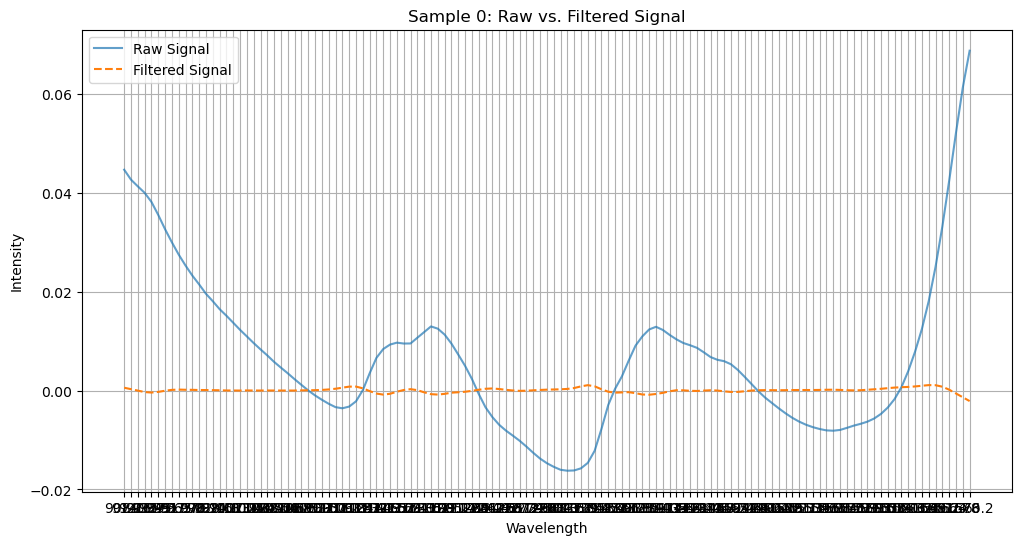

In [18]:
def preprocessing(train_data, test_data, apply_savgol=False, apply_pca=False, apply_variance_threshold=False,
                  apply_correlation=False, apply_random_forest=False):       

    # Drop columns that are not needed
    train_data = train_data.drop(columns=['prod_substance','measure_type_display'])
    test_data = test_data.drop(columns=['prod_substance','measure_type_display'])
    
    non_spectral_cols = ['device_serial', 'substance_form_display']
    spectral_cols = train_data.columns[4:]
    
    # Remove NaN values
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    # One Hot encoding 
    encoder = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(train_data[non_spectral_cols])
    X_test_encoded = encoder.transform(test_data[non_spectral_cols])
    
    # Convert encoded features to DataFrame
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(non_spectral_cols))
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(non_spectral_cols))
    
    train_data_combined = pd.concat([pd.DataFrame(X_train_encoded_df), train_data[spectral_cols].reset_index(drop=True)], axis=1)
    test_data_combined = pd.concat([pd.DataFrame(X_test_encoded_df), test_data[spectral_cols].reset_index(drop=True)], axis=1)
    
    if apply_savgol: 
        # Apply Savitzky-Golay filter
        spectrum_train = train_data_combined[spectral_cols]
        spectrum_test = test_data_combined[spectral_cols]
        
        spectrum_train_filtered = pd.DataFrame(savgol_filter(spectrum_train, 7, 3, deriv=2, axis=1), columns=spectral_cols)
        spectrum_test_filtered = pd.DataFrame(savgol_filter(spectrum_test, 7, 3, deriv=2, axis=1), columns=spectral_cols)
        
        # Standardize the filtered spectrum
        spectrum_train_filtered_standardized = pd.DataFrame(zscore(spectrum_train_filtered, axis=1), columns=spectral_cols)
        spectrum_test_filtered_standardized = pd.DataFrame(zscore(spectrum_test_filtered, axis=1), columns=spectral_cols)
        
        plot_raw_vs_filtered(spectrum_train, spectrum_train_filtered, spectral_cols, sample_idx=0)

        train_data_combined[spectral_cols] = spectrum_train_filtered_standardized
        test_data_combined[spectral_cols] = spectrum_test_filtered_standardized 
        
    if apply_pca:
        # Perform PCA on scaled wavelength columns
        pca = PCA(n_components=5)
        spectral_cols = train_data_combined.columns[49:]
        
        X_train_pca = pca.fit_transform(train_data_combined[spectral_cols])
        X_test_pca = pca.transform(test_data_combined[spectral_cols])

        # Combine PCA components with original data
        X_train_combined = pd.concat([train_data_combined.iloc[:, :50].reset_index(drop=True), 
                                      pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        X_test_combined = pd.concat([test_data_combined.iloc[:, :50].reset_index(drop=True), 
                                     pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        
        train_data_combined = X_train_combined
        test_data_combined = X_test_combined
    
    if apply_variance_threshold:
        # Apply VarianceThreshold
        selector = VarianceThreshold(threshold=0.05)
        train_data_combined = pd.DataFrame(selector.fit_transform(train_data_combined), columns=train_data_combined.columns[selector.get_support(indices=True)])
        test_data_combined = pd.DataFrame(selector.transform(test_data_combined), columns=test_data_combined.columns[selector.get_support(indices=True)])
        print(f"Shape after VarianceThreshold: {train_data_combined.shape}")
    
    if apply_correlation:
        # Compute correlation matrix only for all train_data 
        correlation_matrix = train_data_combined.corr()

        # Visualize correlation matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
        plt.title("Correlation Matrix for All Features")
        
        folder_name = 'Result_plots'
        output_folder = create_folder(path, folder_name)
        plot_path = os.path.join(output_folder, 'correlation_matrix.png')
        plt.savefig(plot_path)
        print(f"Correlation matrix plot saved successfully at '{plot_path}'.")

        # Identify highly correlated features (e.g., |r| > 0.999)
        threshold_high = 0.9999

        print(f"Number of features before removing highly correlated features: {train_data_combined.shape[1]}")
        
        high_corr_pairs = [
            (i, j)
            for i in range(correlation_matrix.shape[0])
            for j in range(i + 1, correlation_matrix.shape[1])
            if abs(correlation_matrix.iloc[i, j]) > threshold_high
        ]
        
        features_to_drop = set()
        for i, j in high_corr_pairs:
            features_to_drop.add(correlation_matrix.columns[j])  # Arbitrarily drop the second feature in the pair

        # Remove the selected features
        train_data_combined = train_data_combined.drop(columns=list(features_to_drop))
        test_data_combined = test_data_combined.drop(columns=list(features_to_drop))
                
        print(f"Number of features after removing highly correlated features: {train_data_combined.shape[1]}")
        print("Highly correlated features:")
        for i, j in high_corr_pairs:
            print(f"{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]}")
            

    if (apply_random_forest and not apply_correlation):
        
        spectral_cols = train_data_combined.columns[49:]
        X_train_rf = train_data_combined[spectral_cols]
        y_train_rf = train_data['PURITY'].iloc[train_data_combined.index].squeeze()
        
        # Create and train random forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=my_seed)
        rf_model.fit(X_train_rf, y_train_rf)

        def test_thresholds():
            
            # Test different thresholds for feature selection
            thresholds = [0.00050,0.00075,0.001,0.0025,0.0048]
            cross_val_scores = []

            for threshold in thresholds:
                # Select features based on threshold
                sfm = SelectFromModel(rf_model, threshold=threshold, prefit=True)
                selected_features = sfm.get_support()
                selected_feature_names = X_train_rf.columns[selected_features]

                # Subset the dataset
                X_train_selected = X_train_rf[selected_feature_names]

                # Compute cross-validation scores
                scores = cross_val_score(rf_model, X_train_selected, y_train_rf, cv=5, scoring='r2')
                mean_score = scores.mean()
                cross_val_scores.append(mean_score)

                print(f"Threshold: {threshold}")
                print(f"Number of selected features: {len(selected_feature_names)}")
                print(f"Cross-validated R^2 score: {mean_score:.4f}")

            # Plot cross-validated R^2 scores vs. thresholds
            plt.figure(figsize=(8, 5))
            plt.plot(thresholds, cross_val_scores, marker='o')
            plt.title("Optimal Feature Selection Threshold vs. Model Performance")
            plt.xlabel("Feature Importance Threshold")
            plt.ylabel("Mean Cross-Validated R² Score")
            plt.grid()
            folder_name = 'Result_plots'
            output_folder = create_folder(path, folder_name)
            plot_path = os.path.join(output_folder, 'R²_Score.png')
            plt.savefig(plot_path)
            print(f"R² Score plot saved successfully at '{plot_path}'.")
            
        #test_thresholds() when tested the best threshold is 0.0005

        # Perform feature selection using the specified threshold
        sfm = SelectFromModel(rf_model, threshold=0.0005, prefit=True)
        selected_features = sfm.get_support()
        selected_feature_names = X_train_rf.columns[selected_features]

        # Apply feature selection to train and test data
        train_data_selected = train_data_combined[selected_feature_names]
        test_data_selected = test_data_combined[selected_feature_names]

        # Add back non-wavelength columns if needed
        non_spectral_cols = [col for col in train_data_combined.columns if col not in spectral_cols]
        train_data_combined = pd.concat([train_data_combined[non_spectral_cols], train_data_selected], axis=1)
        test_data_combined = pd.concat([test_data_combined[non_spectral_cols], test_data_selected], axis=1)

        print(f"Selected {len(selected_feature_names)} features using Random Forest with threshold {0.00050}.")

        # Evaluate feature importances
        feature_importances = rf_model.feature_importances_

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title("Feature Importances")
        plt.xlabel("Feature Index")
        plt.ylabel("Importance Score")
        
        folder_name = 'Result_plots'
        output_folder = create_folder(path, folder_name)
        plot_path = os.path.join(output_folder, 'feature_importance.png')
        plt.savefig(plot_path)
        print(f"Feature Importance plot saved successfully at '{plot_path}'.")
    
    # Add sample_name column back to the combined DataFrames
    train_data_combined = pd.concat([pd.DataFrame({'sample_name': train_data_og['sample_name']}), train_data_combined], axis=1)
    test_data_combined = pd.concat([pd.DataFrame({'sample_name': test_data_og['sample_name']}), test_data_combined], axis=1)
    y_train = train_data['PURITY'].iloc[train_data_combined.index]

    print(f"Shape of OG train data: {train_data_og.shape}")
    print(f"Shape of OG test data: {test_data_og.shape}")
    print(f"Shape of train data: {train_data_combined.shape}")
    print(f"Shape of test data: {test_data_combined.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    
    folder_name = 'Preprocessed-data'

    # Create the folder using the create_folder function
    output_folder = create_folder(path, folder_name)

    # Save the preprocessed data
    train_file_path = os.path.join(output_folder, 'preprocessed_train_data.csv')
    test_file_path = os.path.join(output_folder, 'preprocessed_test_data.csv')
    
    train_data_combined.to_csv(train_file_path, index=False)
    print(f"Train data saved successfully at '{train_file_path}'.")
    
    test_data_combined.to_csv(test_file_path, index=False)
    print(f"Test data saved successfully at '{test_file_path}'.")
    
    return train_data_combined, test_data_combined, y_train

train_data_combined, test_data_combined, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)

# III. LINEAR MODELS

In [19]:
def apply_log_transformation(y):
    return np.log(y)

In [20]:
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    """
    Plots actual vs predicted values and saves the plot to the specified path.
    
    Args:
        y_actual (array-like): Actual target values.
        y_predicted (array-like): Predicted target values.
        title (str): Title of the plot.
        output_path (str): File path to save the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_predicted, y_actual, color='blue', label='Data points')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='y=x')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [21]:
def save_results(submission, y_actual, y_predicted, submission_folder, submission_file, plot_folder, plot_file, title):
    """
    Saves the submission file and the plot in specified folders.

    Args:
        submission (DataFrame): Submission DataFrame to save.
        y_actual (array-like): Actual target values.
        y_predicted (array-like): Predicted target values.
        submission_folder (str): Folder name for submission file.
        submission_file (str): File name for the submission file.
        plot_folder (str): Folder name for the plot.
        plot_file (str): File name for the plot.
        title (str): Title of the plot.
        path (str): Base path for the folders.
    """
    # Create the folders
    submission_path = create_folder(path, submission_folder)
    plot_path = create_folder(path, plot_folder)

    # Save the submission file
    submission_file_path = os.path.join(submission_path, submission_file)
    submission.to_csv(submission_file_path, index=False)
    print(f"Submission file saved successfully at {submission_file_path}.")

    # Save the plot
    plot_actual_vs_predicted(y_actual, y_predicted, title)
    plot_file_path = os.path.join(plot_path, plot_file)
    plt.savefig(plot_file_path)
    print(f"Plot saved successfully at {plot_file_path}.")


In [ ]:
def linear_regression(train_data, test_data, apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
        
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_LR.csv', 'Result_plots', 'linear_regression.png', 'Training Set: Actual vs Predicted Purity')
    
linear_regression(train_data, test_data, apply_y_transformation=False)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.
Training MSE: 4.166521120533866
CV MSE: 1.309797493467286e+18
Score 0.9769230769230769
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission fi

In [ ]:

def polynomial_regression(train_data, test_data, apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", LinearRegression())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
        
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_PR.csv', 'Result_plots', 'polynomial_regression.png', 'Training Set: Actual vs Predicted Purity')
    
polynomial_regression(train_data, test_data, apply_y_transformation=False)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.
Best accuracy: -34.35608939082269
Best parameters: {'polynomial__degree': 2}
Training MSE: 1.4554284452441565e-25
CV MSE: 34.35608939082269
Score 1.0
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '

/var/folders/8t/ylt4vr354kn3p7pxjxkj7__00000gn/T/ipykernel_39675/1888124434.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


In [ ]:
def ridge_regression(train_data, test_data, apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", Ridge(random_state=my_seed))
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__alpha": np.logspace(-12,-3,10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_RR.csv', 'Result_plots', 'ridge_regression.png', 'Training Set: Actual vs Predicted Purity')
    
ridge_regression(train_data,test_data,apply_y_transformation=False)


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.56285e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.45768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.98548e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.06102e-17): result may not be accurate.
  return linalg.s

Best accuracy: -6.604724579014818
Best parameters: {'polynomial__degree': 1, 'regression__alpha': 1e-05}
Training MSE: 4.180466656070147
CV MSE: 6.604724579014818
Score 0.9769230769230769
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission file saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Submissions/sample_submission_RR.csv.
Plot saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/ridge_regression.png.


In [163]:
def lasso_regression(train_data,test_data,apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", Lasso(random_state=my_seed))
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 2, 1),
        "regression__alpha": np.logspace(-12, -3, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_LassoR.csv', 'Result_plots', 'lasso_regression.png', 'Training Set: Actual vs Predicted Purity')    
   
lasso_regression(train_data,test_data,apply_y_transformation=False)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+03, tolerance: 2.530e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e+03, tolerance: 2.524e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best accuracy: -7.047220390170134
Best parameters: {'polynomial__degree': 1, 'regression__alpha': 0.001}
Training MSE: 5.034091916141048


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+03, tolerance: 2.530e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e+03, tolerance: 2.524e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

CV MSE: 7.047220390170134
Score 0.9676923076923077
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission file saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Submissions/sample_submission_LassoR.csv.
Plot saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/lasso_regression.png.


In [164]:
def elasticnet_regression(train_data,test_data,apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", ElasticNet(random_state=my_seed))
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 2, 1),
        "regression__alpha": np.logspace(-12, -3, 10),
        "regression__l1_ratio": np.linspace(0, 1, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_ElasticNet.csv', 'Result_plots', 'elasticnet_regression.png', 'Training Set: Actual vs Predicted Purity')
    
elasticnet_regression(train_data,test_data,apply_y_transformation=False)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+03, tolerance: 2.530e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e+03, tolerance: 2.524e+01 Linear regression models with null weight for the l1 regularization term are more efficientl

Best accuracy: -6.909322150235044
Best parameters: {'polynomial__degree': 1, 'regression__alpha': 0.001, 'regression__l1_ratio': 0.4444444444444444}
Training MSE: 5.351353208213912


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e+03, tolerance: 2.524e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.924e+03, tolerance: 2.665e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

CV MSE: 6.909322150235044
Score 0.9584615384615385
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission file saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Submissions/sample_submission_ElasticNet.csv.
Plot saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/elasticnet_regression.png.


In [ ]:
def orthogonal_matching_pursuit(train_data, test_data):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", OrthogonalMatchingPursuit())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 3, 1),
        "regression__n_nonzero_coefs": range(1, 100, 10)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_OMP.csv', 'Result_plots', 'orthogonal_matching_pursuit.png', 'Training Set: Actual vs Predicted Purity')
    
orthogonal_matching_pursuit(train_data, test_data)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.
Best accuracy: -5.363580001148864
Best parameters: {'polynomial__degree': 2, 'regression__n_nonzero_coefs': 91}
Training MSE: 3.269952373854236
CV MSE: 5.363580001148864
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots'

In [152]:
def huber_regression(train_data, test_data, apply_y_transformation=True):
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
        
    # Define the parameter grid for epsilon
    param_grid = {'epsilon': np.arange(1, 2, 0.5)}
     
    # Initialize the HuberRegressor
    huber = HuberRegressor()
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=huber, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_huber = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_huber.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_huber, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_huber.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_HR.csv', 'Result_plots', 'huber_regression.png', 'Training Set: Actual vs Predicted Purity')
    
huber_regression(train_data, test_data)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to conv

Best parameters: {'epsilon': 1.5}
Training MSE: 23.492510952489262


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to conv

CV MSE: 0.0852502584533183
Score 0.0007692307692307692
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission file saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Submissions/sample_submission_HR.csv.
Plot saved successfully at /Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/huber_regression.png.


In [153]:
def bayesian_ridge_regression(train_data, test_data, apply_y_transformation=False):
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = apply_log_transformation(y_train)
    
    # Define the objective function for Bayesian Optimization
    def objective(alpha_1, alpha_2, lambda_1, lambda_2):
        model = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        return -cv_scores.mean()
    
    # Define the parameter bounds
    params_bayesian_ridge = {
        'alpha_1': (1e-6, 1e-3),
        'alpha_2': (1e-6, 1e-3),
        'lambda_1': (1e-6, 1e-3),
        'lambda_2': (1e-6, 1e-3)
    }
    
    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(f=objective, pbounds=params_bayesian_ridge, random_state=my_seed)
    
    # Maximize the objective function
    optimizer.maximize(init_points=10, n_iter=50)
    
    # Get the best parameters
    best_params = optimizer.max['params']
    print("Best parameters:", best_params)
    
    # Train the final model with the best parameters
    bayesian_ridge = BayesianRidge(**best_params)
    bayesian_ridge.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = bayesian_ridge.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(bayesian_ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = bayesian_ridge.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.expm1(y_test_pred)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_BRR.csv', 'Result_plots', 'bayesian_ridge_regression.png', 'Training Set: Actual vs Predicted Purity')
    
bayesian_ridge_regression(train_data, test_data, apply_y_transformation=False)


/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.
|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |
-------------------------------------------------------------------------
| 1         | 6.793     | 0.0003752 | 0.0009508 | 0.0007323 | 0.0005991 |
| 2         | 6.793     | 0.0001569 | 0.0001568 | 5.903e-05

# IV. NON-LINEAR MODELS

In [167]:
def random_forest_linear_regression(train_data, test_data, apply_y_transformation=False):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if apply_y_transformation:
        y_train = np.log1p(y_train)  # Apply log transformation
        
    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=300, random_state=my_seed)
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = rf.predict(X_train)
    if apply_y_transformation:
        y_train_pred = np.exp(y_train_pred)  # Apply inverse log transformation
        y_train_original = np.exp(y_train)
        mse = mean_squared_error(y_train_original, y_train_pred)
    else:
        mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = rf.predict(X_test)
    if apply_y_transformation:
        y_test_pred = np.exp(y_test_pred)  # Apply inverse log transformation
    
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Calculate and print custom scoring
    score = scoring(y_train_pred, y_train)
    print('Score', score)
    
    save_results(submission, y_train, y_train_pred, 'Submissions', 'sample_submission_RFLR.csv', 'Result_plots', 'random_forest_linear_regression.png', 'Training Set: Actual vs Predicted Purity')
    
random_forest_linear_regression(train_data, test_data, apply_y_transformation=False)
    

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.
Training MSE: 0.6356635132351521
CV MSE: 5.388484985468246
Score 0.9992307692307693
Folder 'Submissions' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Submission file 

In [ ]:
def neural_network(train_data,test_data):
    
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    y_train_std = StandardScaler().fit(y_train.values.reshape(-1, 1))
    
    # Standardize y_train
    y_train_nn = y_train_std.transform(y_train.values.reshape(-1, 1))

        
    X_train, y_train_nn, X_test = map(
        lambda array: torch.tensor(array, dtype=torch.float32),
        [X_train.values, y_train_nn, X_test.values]
    )  
    
    training_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train_nn),
        batch_size = 32,
        shuffle = True,
    )
    
    class NeuralNet1(torch.nn.Module):
        def __init__(self):
            super(NeuralNet1, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(X_train.shape[1], 64),
                torch.nn.Dropout(0.7),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1),
            )
        def forward(self, x):
            return self.layers(x)
    
    epochs = 100
    
    model = NeuralNet1()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
    
    model.train()
    for epoch in tqdm.tqdm(range(epochs)):
        for data, target in training_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = torch.sqrt(loss_func(pred, target))
            loss.backward()
            optimizer.step()
            
    # Evaluation
    with torch.no_grad():
        model.eval()
        train_preds = y_train_std.inverse_transform(model(X_train).detach().numpy())
        train_gt = y_train_std.inverse_transform(y_train_nn.detach().numpy())
        train_loss = np.sqrt(mean_squared_error(train_preds, train_gt))

        test_preds = y_train_std.inverse_transform(model(X_test).detach().numpy())

    print(f'{train_loss=}')
    submission = submission_file(test_preds.squeeze())
    
    # Calculate and print custom scoring
    score = scoring(train_preds, y_train)
    print('Score', score)
    
    save_results(submission, train_gt, train_preds, 'Submissions', 'sample_submission_NN.csv', 'Result_plots', 'neural_network.png', 'Training Set: Actual vs Predicted Purity')
      
neural_network(train_data, test_data)

/Users/maelysclerget/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Folder 'Result_plots' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Plot saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Result_plots/savitzky_golay_filter.png'.
Shape of OG train data: (1300, 132)
Shape of OG test data: (608, 130)
Shape of train data: (1300, 175)
Shape of test data: (608, 175)
Shape of y_train: (1300,)
Folder 'Preprocessed-data' already exists at '/Users/maelysclerget/Desktop/ML/bio322_project/'.
Train data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_train_data.csv'.
Test data saved successfully at '/Users/maelysclerget/Desktop/ML/bio322_project/Preprocessed-data/preprocessed_test_data.csv'.


In [2]:
def loss(y_pred, y_hat):
    return torch.sqrt(torch.mean((y_pred - y_hat) ** 2))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row_X = self.X.iloc[idx]
        row_y = self.y.iloc[idx]
        x = torch.tensor(row_X, dtype=torch.float)
        y = torch.tensor(row_y, dtype=torch.float)
        return x, y

# Neural Network
class Network(torch.nn.Module):
    def __init__(self, N_init, N1, N2, N3, N4):
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(N_init, N1)
        self.linear2 = torch.nn.Linear(N1, N2)
        self.linear3 = torch.nn.Linear(N2, N3)
        self.linear4 = torch.nn.Linear(N3, N4)
        self.linear5 = torch.nn.Linear(N4, 1)  # Output layer

    def forward(self, x):
        z = torch.nn.functional.selu(self.linear1(x))
        z = torch.nn.functional.selu(self.linear2(z))
        z = torch.nn.functional.selu(self.linear3(z))
        z = torch.nn.functional.selu(self.linear4(z))
        z = self.linear5(z)
        return z

# Early Stopping Class
class EarlyStopTraining:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, loss, model):
        if self.best_loss is None:
            self.best_loss = loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            
def objective(trial, train_data, y_train):
    
    num_epochs = 90
    batch_size = 32
    
    N1 = trial.suggest_int('N1', 80, 170)
    N2 = trial.suggest_int('N2', 50, 120)
    N3 = trial.suggest_int('N3', 20, 80)
    N4 = trial.suggest_int('N4', 5, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=my_seed)
    val_losses = []

    for train_index, val_index in kf.split(train_data):
        # Split data into training and validation sets
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]

        # Create Datasets and DataLoaders
        train_dataset = CustomDataset(train_fold, y_train_fold)
        val_dataset = CustomDataset(val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Initialize model, optimizer, and early stopping
        model = Network(train_fold.shape[1], N1, N2, N3, N4)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)
        early_stopping = EarlyStopTraining(patience=10)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss_avg = 0

            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss_value = loss(y_pred, y_batch.unsqueeze(-1))
                loss_value.backward()
                optimizer.step()
                train_loss_avg += loss_value.item()

            train_loss_avg /= len(train_loader)
            early_stopping(loss_value, model)

            if early_stopping.early_stop:
                break

        # Load the best model and evaluate on validation set
        model.load_state_dict(early_stopping.best_model)
        model.eval()

        x_val = torch.tensor(val_fold.values, dtype=torch.float)
        y_val_pred = model(x_val)
        val_loss = loss(y_val_pred, torch.tensor(y_val_fold.values).unsqueeze(-1))
        val_losses.append(val_loss.item())

    return np.mean(val_losses)

In [17]:
def optimisation():
    
    # Seed for reproducibility
    np.random.seed(my_seed)
    torch.manual_seed(my_seed)
    
     # Preprocess once before optimization
    train_data, _, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    train_data = train_data.drop(columns=["sample_name"])

    # Wrap the objective function to pass additional arguments
    def wrapped_objective(trial):
        return objective(trial, train_data, y_train)

    # Run Optuna study
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=my_seed))
    study.optimize(wrapped_objective, n_trials=20)

    # Print the best hyperparameters
    print("Best hyperparameters: ", study.best_params)

In [ ]:
def nn_early_stopping_with_validation(train_data,test_data):

    # Preprocessing
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)

    # Drop sample_name column
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Standardize y_train and y_val
    y_scaler = StandardScaler().fit(y_train.values.reshape(-1, 1))
    y_train_nn = y_scaler.transform(y_train.values.reshape(-1, 1))
    y_val_nn = y_scaler.transform(y_val.values.reshape(-1, 1))

    # Convert to PyTorch tensors
    X_train, y_train_nn, X_val, y_val_nn, X_test = map(
        lambda array: torch.tensor(array, dtype=torch.float32),
        [X_train.values, y_train_nn, X_val.values, y_val_nn, X_test.values]
    )

    # Dataloader for training and validation
    training_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train_nn),
        batch_size=32,
        shuffle=True,
    )
    validation_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val_nn),
        batch_size=32,
        shuffle=False,
    )

    # Define the Neural Network (same as before)
    class NeuralNet(nn.Module):
        def __init__(self, input_dim, N1, N2, N3, N4):
            super(NeuralNet, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(input_dim, N1),
                nn.Dropout(0.5),
                torch.nn.Linear(N1, N2),
                nn.Dropout(0.5),
                torch.nn.Linear(N2, N3),
                nn.Dropout(0.5),
                torch.nn.Linear(N3, N4),
                nn.Dropout(0.5),
                torch.nn.Linear(N4, 1),
            )

        def forward(self, x):
            return self.layers(x)

    # Initialize the model, loss, and optimizer
    model = NeuralNet(
        input_dim=X_train.shape[1],
        N1=153,
        N2=71,
        N3=25,
        N4=15,
    )
    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0007591104805282694,
        weight_decay=1e-3,
    )

    # Early Stopping Parameters
    patience = 10
    min_delta = 1e-4
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # Store training and validation losses for plotting
    training_losses = []
    validation_losses = []

    # Training Loop with Early Stopping
    epochs = 100
    model.train()
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        for data, target in training_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = loss_func(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Average training loss for the epoch
        epoch_loss /= len(training_dataloader)
        training_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in validation_dataloader:
                pred = model(data)
                loss = loss_func(pred, target)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        validation_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Check for early stopping
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    folder_name = 'Result_plots'
    output_folder = create_folder(path, folder_name)
    plot_path = os.path.join(output_folder, 'Loss_over_epochs.png')
    plt.savefig(plot_path)
    print(f"Loss over epochs plot saved successfully at '{plot_path}'.")

    # Evaluation
    with torch.no_grad():
        model.eval()
        train_preds = y_scaler.inverse_transform(model(X_train).detach().numpy())
        train_gt = y_scaler.inverse_transform(y_train_nn.detach().numpy())
        train_loss = np.sqrt(mean_squared_error(train_preds, train_gt))

        val_preds = y_scaler.inverse_transform(model(X_val).detach().numpy())
        val_gt = y_scaler.inverse_transform(y_val_nn.detach().numpy())
        val_loss = np.sqrt(mean_squared_error(val_preds, val_gt))

        test_preds = y_scaler.inverse_transform(model(X_test).detach().numpy())

    print(f'{train_loss=}, {val_loss=}')
    
    # Save submission file
    submission = submission_file(test_preds.squeeze())
    
    # Calculate and print custom scoring
    score = scoring(train_preds, y_train)
    print('Score', score)
    
    save_results(submission, train_gt, train_preds, 'Submissions', 'sample_submission_NN.csv', 'Result_plots', 'neural_network.png', 'Training Set: Actual vs Predicted Purity')

nn_early_stopping_with_validation(train_data, test_data)

In [ ]:
def submission_nn_optimized():
    
    # Best parameters obtained from Optuna
    best_params = {
        'N1': 153,
        'N2': 71,
        'N3': 25,
        'N4': 15,
        'learning_rate': 0.0007591104805282694,
    }
    
    # Preprocessing
    X_train, X_test, y_train = preprocessing(train_data, test_data, apply_savgol=True, apply_pca=False, apply_variance_threshold=False, apply_correlation=False, apply_random_forest=False)
    
    # Drop unnecessary columns
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    # Standardize y_train
    y_train_std = StandardScaler().fit(y_train.values.reshape(-1, 1))
    y_train_nn = y_train_std.transform(y_train.values.reshape(-1, 1))

    # Convert data to PyTorch tensors
    X_train, y_train_nn, X_test = map(
        lambda array: torch.tensor(array, dtype=torch.float32),
        [X_train.values, y_train_nn, X_test.values]
    )  
    
    # DataLoader for training
    training_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train_nn),
        batch_size=32,
        shuffle=True,
    )
    
    # Define Neural Network with the best parameters
    class NeuralNetOptimized(torch.nn.Module):
        def __init__(self, input_dim, N1, N2, N3, N4):
            super(NeuralNetOptimized, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(input_dim, N1),
                nn.Dropout(0.5),
                torch.nn.Linear(N1, N2),
                nn.Dropout(0.5),
                torch.nn.Linear(N2, N3),
                nn.Dropout(0.5),
                torch.nn.Linear(N3, N4),
                nn.Dropout(0.5),
                torch.nn.Linear(N4, 1),
            )
        def forward(self, x):
            return self.layers(x)
    
    # Initialize the model
    model = NeuralNetOptimized(
        input_dim=X_train.shape[1],
        N1=best_params['N1'],
        N2=best_params['N2'],
        N3=best_params['N3'],
        N4=best_params['N4'],
    )
    
    # Define loss function and optimizer
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=1e-3,
    )
    
    # Training loop
    epochs = 100
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc="Training Epochs"):
        for data, target in training_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = torch.sqrt(loss_func(pred, target))  # RMSE
            loss.backward()
            optimizer.step()
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        # Predict on training set
        train_preds = y_train_std.inverse_transform(model(X_train).detach().numpy())
        train_gt = y_train_std.inverse_transform(y_train_nn.detach().numpy())
        train_loss = np.sqrt(mean_squared_error(train_preds, train_gt))

        # Predict on test set
        test_preds = y_train_std.inverse_transform(model(X_test).detach().numpy())

    # Print training loss
    print(f'{train_loss=}')
    
    # Save submission file
    submission = submission_file(test_preds.squeeze())
    save_results(submission, train_gt, train_preds, 'Submissions', 'sample_submission_NN_optimized.csv', 'Result_plots', 'neural_network_optimized.png', 'Training Set: Actual vs Predicted Purity')  

In [ ]:
def mix_predictions(alpha=0.65):
    
    linear = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/Submissions-files/sample_submission_RIDGE.csv')
    non_linear = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/Submissions-files/sample_submission_NN.csv')
    
    linear_purity = linear['PURITY']
    non_linear_purity = non_linear['PURITY']
    final_1 = linear_purity*alpha + non_linear_purity*(1-alpha)
    submission_final = pd.DataFrame({
        'ID': linear['ID'],
        'PURITY': final_1
    })
    submission_final.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/Submissions-files/sample_submission_mixed.csv', index=False)
    print('Submission file saved successfully.')  

# V. CONCLUSIONS

Our best model is Ridge